In [2]:
from datasets import load_dataset

e:\Anaconda\envs\mp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 加载数据集
dataset = load_dataset("CNGR/CN_Gesture_Recognition")

# 数据集默认会缓存到本地路径（查看路径）：
print(dataset.cache_files)

Generating train split: 815 examples [00:00, 1028.93 examples/s]

{'train': [{'filename': 'C:\\Users\\Administrator\\.cache\\huggingface\\datasets\\CNGR___cn_gesture_recognition\\default\\0.0.0\\f4d9164b6e42175f921579dc11f8654b4f4c7ccc\\cn_gesture_recognition-train.arrow'}]}


In [5]:
# 指定自定义保存路径（可选）
dataset.save_to_disk("./data/CN_Gesture_Recognition")

Saving the dataset (4/4 shards): 100%|██████████| 815/815 [00:05<00:00, 136.29 examples/s]


In [1]:
from datasets import load_from_disk

dataset = load_from_disk("./data/CN_Gesture_Recognition")
print(dataset)  # 查看数据集结构

e:\Anaconda\envs\mp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 815
    })
})


数据集结构:
 DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 815
    })
})

标签映射: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


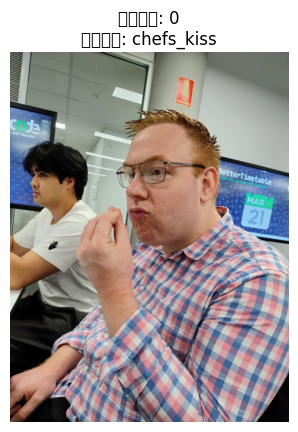

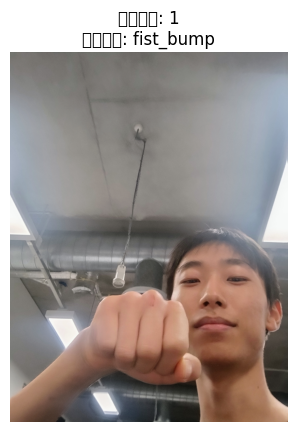

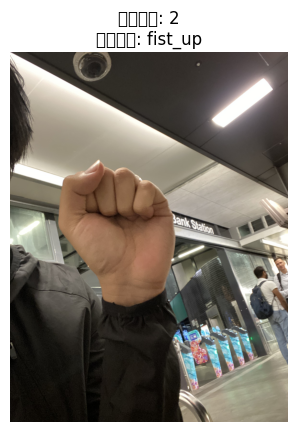

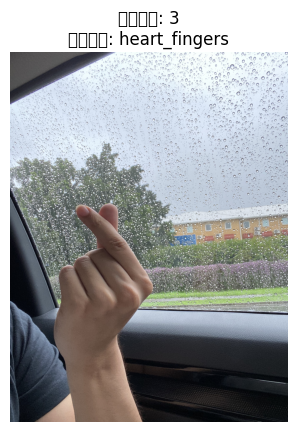

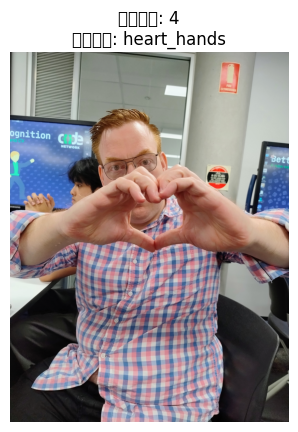

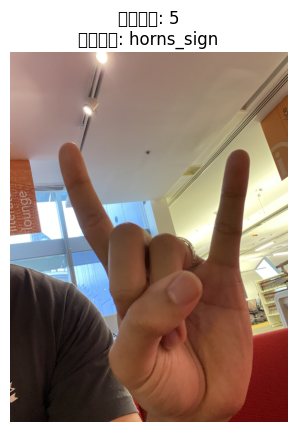

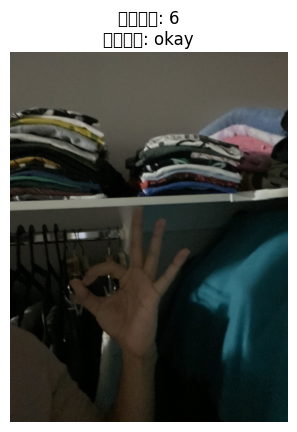

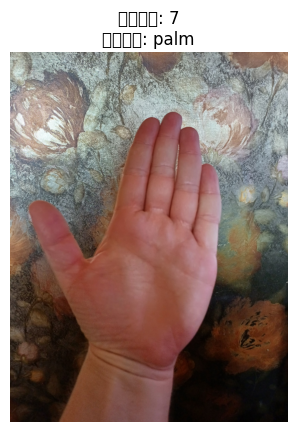

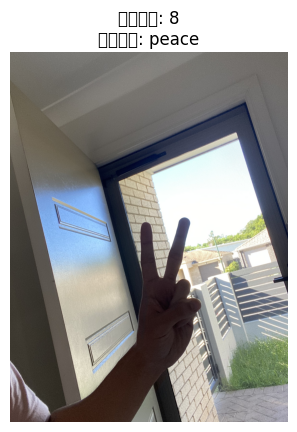

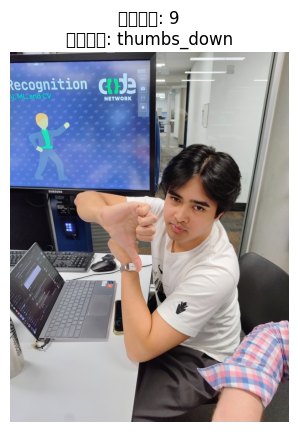

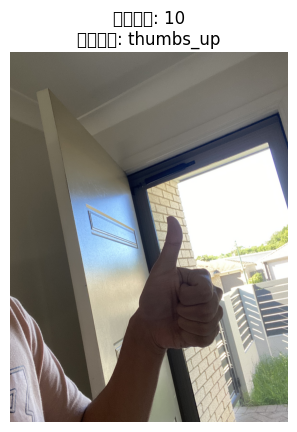

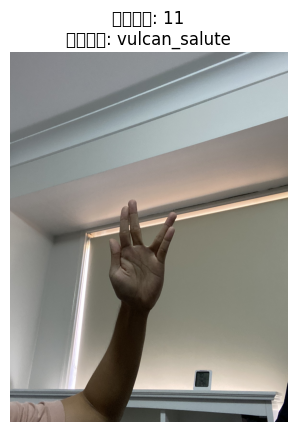


各标签分布 (标签数字 -> 名称: 数量)
标签 0（chefs_kiss）: 66 个样本
标签 1（fist_bump）: 65 个样本
标签 2（fist_up）: 72 个样本
标签 3（heart_fingers）: 69 个样本
标签 4（heart_hands）: 74 个样本
标签 5（horns_sign）: 70 个样本
标签 6（okay）: 67 个样本
标签 7（palm）: 71 个样本
标签 8（peace）: 68 个样本
标签 9（thumbs_down）: 63 个样本
标签 10（thumbs_up）: 67 个样本
标签 11（vulcan_salute）: 63 个样本


In [13]:
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

# 1. 打印数据集结构
print("数据集结构:\n", dataset)

# 2. 获取标签映射关系（假设标签名称在features中）
label_feature = dataset["train"].features["label"]
label_names = label_feature.names if hasattr(label_feature, "names") else []


# 3. 显示前3张图片及标签信息
# 获取所有唯一标签
unique_labels = sorted(set(dataset["train"]["label"]))
print("\n标签映射:", unique_labels)
# 为每个标签显示一张示例图
for label_num in unique_labels:
    # 找到该标签的第一个样本
    sample = next((s for s in dataset["train"] if s["label"] == label_num), None)
    if sample is None:
        print(f"标签 {label_num} 无样本")
        continue
    
    # 加载图像
    image = sample["image"]
    if isinstance(image, str):
        image = Image.open(image)
    
    # 获取标签名称
    label_str = label_names[label_num] if label_names else f"未知标签{label_num}"
    
    # 显示图像和标签
    plt.figure()
    plt.imshow(image)
    plt.title(f"标签数字: {label_num}\n标签名称: {label_str}")
    plt.axis('off')
    plt.show()

# 4. 统计标签分布（兼容两种字段名）
labels = dataset["train"]["label"] if "label" in dataset["train"].column_names else dataset["train"]["class"]
label_counts = Counter(labels)

# 获取标签名称映射（假设label字段是ClassLabel类型）
label_feature = dataset["train"].features["label"]
label_names = label_feature.names if hasattr(label_feature, "names") else []

print("\n各标签分布 (标签数字 -> 名称: 数量)")
for label_num, count in label_counts.items():
    # 转换数字标签为名称（如果存在映射）
    label_str = label_names[label_num] if label_names else "无名称映射"
    print(f"标签 {label_num}（{label_str}）: {count} 个样本")

In [17]:
from datasets import load_from_disk
from PIL import Image
import numpy as np
import os
import shutil

def convert_arrow_to_images(dataset, output_dir="converted_dataset", split="train"):
    """
    万能转换函数，支持所有 PIL 兼容格式
    """
    # 清空并创建输出目录
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    
    # 获取标签映射
    label_feature = dataset[split].features["label"]
    label_names = label_feature.names if hasattr(label_feature, "names") else []
    
    # 遍历数据集
    for idx, sample in enumerate(dataset[split]):
        try:
            # 获取图像对象
            image = sample["image"]
            
            # 统一转换为 PIL.Image 对象
            if isinstance(image, Image.Image):  # 已经是 PIL 对象
                img = image
            elif isinstance(image, str):        # 路径字符串
                img = Image.open(image)
            elif isinstance(image, bytes):      # 字节流
                img = Image.frombytes("RGB", (image.width, image.height), image.tobytes())
            elif isinstance(image, np.ndarray):  # numpy 数组
                img = Image.fromarray(image)
            else:
                raise ValueError(f"不支持的图像类型: {type(image)}")
            
            # 获取标签信息
            label_num = sample["label"]
            label_str = label_names[label_num] if label_names else str(label_num)
            
            # 创建标签子目录
            label_dir = os.path.join(output_dir, label_str)
            os.makedirs(label_dir, exist_ok=True)
            
            # 自动检测格式并保存
            if img.format:  # 优先使用原始格式 (JPEG/PNG等)
                output_path = os.path.join(label_dir, f"image_{idx:04d}.{img.format.lower()}")
            else:           # 无格式信息则保存为 PNG
                output_path = os.path.join(label_dir, f"image_{idx:04d}.png")
            
            # 保留所有元数据 (EXIF等)
            img.save(output_path, format=img.format, quality=100)
            
            print(f"已保存：{output_path} | 格式：{img.format} | 尺寸：{img.size[0]}x{img.size[1]}")
            
        except Exception as e:
            print(f"处理样本 {idx} 失败: {str(e)}")
            continue


# 使用示例
dataset = load_from_disk("./data/CN_Gesture_Recognition")
convert_arrow_to_images(dataset, output_dir="gesture_dataset_raw")

已保存：gesture_dataset_raw\chefs_kiss\image_0000.png | 格式：None | 尺寸：3072x4080
已保存：gesture_dataset_raw\chefs_kiss\image_0001.png | 格式：None | 尺寸：1728x2304
已保存：gesture_dataset_raw\chefs_kiss\image_0002.jpeg | 格式：JPEG | 尺寸：2316x3088
已保存：gesture_dataset_raw\chefs_kiss\image_0003.jpeg | 格式：JPEG | 尺寸：1440x960
已保存：gesture_dataset_raw\chefs_kiss\image_0004.png | 格式：None | 尺寸：3072x4080
已保存：gesture_dataset_raw\chefs_kiss\image_0005.png | 格式：None | 尺寸：3024x4032
已保存：gesture_dataset_raw\chefs_kiss\image_0006.jpeg | 格式：JPEG | 尺寸：1440x960
已保存：gesture_dataset_raw\chefs_kiss\image_0007.png | 格式：None | 尺寸：2316x3088
已保存：gesture_dataset_raw\chefs_kiss\image_0008.jpeg | 格式：JPEG | 尺寸：1280x720
已保存：gesture_dataset_raw\chefs_kiss\image_0009.jpeg | 格式：JPEG | 尺寸：1280x720
已保存：gesture_dataset_raw\chefs_kiss\image_0010.jpeg | 格式：JPEG | 尺寸：1280x720
已保存：gesture_dataset_raw\chefs_kiss\image_0011.jpeg | 格式：JPEG | 尺寸：2316x3088
已保存：gesture_dataset_raw\chefs_kiss\image_0012.png | 格式：None | 尺寸：3072x4080
已保存：gesture_dataset_raw